In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import timeit

from torch.autograd import Variable

import visdom
import numpy as np
import matplotlib.pyplot as plt
import sklearn

%matplotlib inline
%load_ext autoreload
%autoreload 2

from sklearn.preprocessing import OneHotEncoder
from uppercase import Dataset

In [3]:
window_size = 5
alphabet_size = 100

train = Dataset("data/uppercase_data_train.txt", window_size, alphabet=alphabet_size)
dev = Dataset("data/uppercase_data_dev.txt", window_size, alphabet=train.alphabet)
test = Dataset("data/uppercase_data_test.txt", window_size, alphabet=train.alphabet)

In [4]:
X, y = test.all_data()
X_test, y_test = X[:, :], y[:,]
X_test = OneHotEncoder(alphabet_size, sparse=False).fit_transform(X_test)

In [13]:
import visdom
vis = visdom.Visdom()

def torch_batch(batch, onehot=False):
    X, y = batch
    if onehot:
        X = OneHotEncoder(alphabet_size, sparse=False).fit_transform(X)
        
    X = Variable(torch.from_numpy(X).float()).cuda()
    y = Variable(torch.from_numpy(y.astype(np.long))).cuda()
    
    return X, y

def accuracy(scores, y):
    return (scores.round().long() == y).float().mean().data[0]

In [14]:
class Ravel(nn.Module):
    def forward(self, x):
        return x.view(-1)

model = nn.Sequential(
    nn.Linear(alphabet_size*(2*window_size+1), 200),
    nn.ReLU(),
    nn.Linear(200, 200),
    nn.ReLU(),
    nn.Linear(200, 200),
    nn.ReLU(),
    nn.Linear(200, 200),
    nn.ReLU(),
    nn.Linear(200, 1),
    nn.Sigmoid(),
    Ravel(),
).cuda()

optimizer = optim.Adam(model.parameters())
loss = nn.BCELoss()

In [15]:
losses = []
accuracies = []

dev_losses = []
dev_accuracies = []

i = 0
for _ in range(2):
    while not train.epoch_finished():
        i += 1
        X, y = torch_batch(train.next_batch(20), onehot=True)

        optimizer.zero_grad()
        scores = model(X)
        
        output = loss(scores, y.float())
        output.backward()
        optimizer.step()
        
        if i % 20 == 0:
            losses.append(output.data[0])
            accuracies.append(accuracy(scores, y))

            vis.line(np.array(losses), win="loss", opts={"title": "train/loss"})
            vis.line(np.array(accuracies), win="acc", opts={"title": "train/acc"})

        if i % 200 == 0:
            idx = np.random.choice(y_test.shape[0], 5000)
            X, y = torch_batch((X_test[idx,:], y_test[idx]))
            
            scores = model(X)
            output = loss(scores, y.float())
        
            dev_losses.append(output.data[0])
            dev_accuracies.append(accuracy(scores, y))
            vis.line(np.array(dev_losses), win="dev/loss", opts={"title": "dev/loss"})
            vis.line(np.array(dev_accuracies), win="dev/acc", opts={"title": "dev/acc"})


Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/darth/.miniconda/lib/python3.6/site-packages/visdom/__init__.py", line 261, in _send
    data=json.dumps(msg),
  File "/home/darth/.miniconda/lib/python3.6/site-packages/requests/api.py", line 112, in post
    return request('post', url, data=data, json=json, **kwargs)
  File "/home/darth/.miniconda/lib/python3.6/site-packages/requests/api.py", line 58, in request
    return session.request(method=method, url=url, **kwargs)
  File "/home/darth/.miniconda/lib/python3.6/site-packages/requests/sessions.py", line 508, in request
    resp = self.send(prep, **send_kwargs)
  File "/home/darth/.miniconda/lib/python3.6/site-packages/requests/sessions.py", line 618, in send
    r = adapter.send(request, **kwargs)
  File "/home/darth/.miniconda/lib/python3.6/site-packages/requests/adapters.py", line 440, in send
    timeout=timeout
  File "/home/darth/.miniconda/lib/python3.6/site-packages/urllib3/connectionpool.py", line 601, in urlopen
    chunke

KeyboardInterrupt: 

In [20]:
import torchvision
import torchvision.transforms as transforms

In [21]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [23]:
batch_size = 4
num_workers = 4

trainset = torchvision.datasets.CIFAR10(root="./data/cifar",
                                       train=True,
                                       download=True,
                                       transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                         shuffle=True, num_workers=num_workers)

testset = torchvision.datasets.CIFAR10(root="./data/cifar",
                                      train=False,
                                      download=True,
                                      transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                        shuffle=False, num_workers=num_workers)

Files already downloaded and verified
Files already downloaded and verified


In [24]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [25]:
vis.image(np.random.randn(50, 20))

'window_360c333c594dc2'

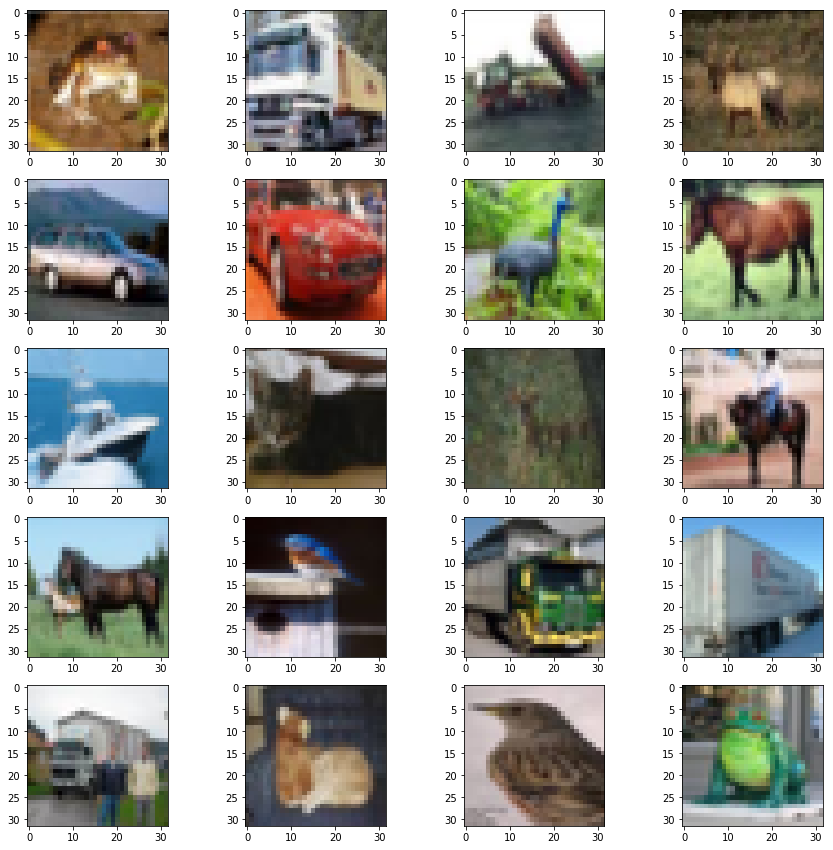

In [54]:
plt.figure(figsize=(15,15))
for i in range(20):    
    plt.subplot(5,4,i+1)
    imshow(trainset[i][0])

In [55]:
from tpot import TPOTClassifier
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

digits = load_digits()
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target,
                                                    train_size=0.75, test_size=0.25)

tpot = TPOTClassifier(generations=5, population_size=20, verbosity=2)
tpot.fit(X_train, y_train)
print(tpot.score(X_test, y_test))
tpot.export('tpot_mnist_pipeline.py')

Optimization Progress:  33%|███▎      | 40/120 [01:38<02:54,  2.18s/pipeline]

Generation 1 - Current best internal CV score: 0.9531815960837827


Optimization Progress:  50%|█████     | 60/120 [02:14<01:24,  1.41s/pipeline]

Generation 2 - Current best internal CV score: 0.9613777595795551


Optimization Progress:  67%|██████▋   | 80/120 [02:50<00:54,  1.36s/pipeline]

Generation 3 - Current best internal CV score: 0.9613777595795551


Optimization Progress:  83%|████████▎ | 100/120 [03:37<00:32,  1.64s/pipeline]

Generation 4 - Current best internal CV score: 0.9673428845759077


Generation 5 - Current best internal CV score: 0.9747678043899887

Best pipeline: KNeighborsClassifier(GradientBoostingClassifier(input_matrix, learning_rate=0.5, max_depth=9, max_features=0.4, min_samples_leaf=6, min_samples_split=13, n_estimators=100, subsample=0.55), n_neighbors=10, p=1, weights=distance)
0.9777777777777777


True

In [56]:
!cat tpot_mnist_pipeline.py

import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator

# NOTE: Make sure that the class is labeled 'target' in the data file
tpot_data = pd.read_csv('PATH/TO/DATA/FILE', sep='COLUMN_SEPARATOR', dtype=np.float64)
features = tpot_data.drop('target', axis=1).values
training_features, testing_features, training_target, testing_target = \
            train_test_split(features, tpot_data['target'].values, random_state=42)

# Score on the training set was:0.9747678043899887
exported_pipeline = make_pipeline(
    StackingEstimator(estimator=GradientBoostingClassifier(learning_rate=0.5, max_depth=9, max_features=0.4, min_samples_leaf=6, min_samples_split=13, n_estimators=100, subsample=0.55)),
    KNeighborsClassifier(n_neighbors=10, p=1, weights="distanc